In [1]:
# Python 3.8.10 64-bit
# Local Jupyter Notebook in VS Code

# Install requirements as listed in pyweka documentation.
# http://fracpete.github.io/python-weka-wrapper3/install.html#windows

# Oracle JDK required.
# https://www.oracle.com/java/technologies/downloads/#jdk17-windows

Install packages and libraries

In [2]:
%pip install numpy-1.21.5+vanilla-cp38-cp38-win_amd64.whl
%pip install javabridge-1.0.19-cp38-cp38-win_amd64.whl
%pip install matplotlib-3.5.1-cp38-cp38-win_amd64.whl

Processing c:\users\jc\desktop\onedrive - kennesaw state university\mscy\gra\datasets\iot-23\numpy-1.21.5+vanilla-cp38-cp38-win_amd64.whl
numpy is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
Processing c:\users\jc\desktop\onedrive - kennesaw state university\mscy\gra\datasets\iot-23\javabridge-1.0.19-cp38-cp38-win_amd64.whl
javabridge is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
Processing c:\users\jc\desktop\onedrive - kennesaw state university\mscy\gra\datasets\iot-23\matplotlib-3.5.1-cp38-cp38-win_amd64.whl
matplotlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use upda

In [3]:
%pip install python-weka-wrapper3
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# install zeek analysis tool package
# https://github.com/SuperCowPowers/zat/tree/master/zat

%pip install zat

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install python packages typically used with weka. Add / Remove items as needed.

import os
import zat
import glob
import tempfile
import itertools
import traceback
import numpy as np
import pandas as pd
import weka.core.jvm as jvm
import matplotlib.pyplot as plt
import weka.plot.classifiers as plot_cls
import plotly.graph_objects as go
import weka.plot.graph as graph
import weka.plot.graph as plot_graph
import weka.core.typeconv as typeconv
import weka.core.converters as converters
import plotly.graph_objects as go
import weka.plot.classifiers as plcls

from weka.filters import Filter
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
from weka.core.classes import from_commandline
from weka.core.classes import to_commandline
from weka.classifiers import Evaluation
from weka.core.classes import Random
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random, from_commandline
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier
from weka.classifiers import PredictionOutput, Kernel, KernelClassifier
from weka.experiments import SimpleCrossValidationExperiment, SimpleRandomSplitExperiment, Tester, ResultMatrix

Load data from log file and create both dataframe and csv file

In [7]:
# Create a Pandas dataframe from network log using zat logtodataframe function 
# https://mcfp.felk.cvut.cz/publicDatasets/IoT-23-Dataset/IndividualScenarios/CTU-IoT-Malware-Capture-20-1/bro/

log_to_df = LogToDataFrame()
log_df = log_to_df.create_dataframe("conn.log.labeled")

# Print out the head of the dataframe
# log_df.head()

# Save dataframe to csv file

log_df.to_csv("testzat.csv")

In [8]:
log_df.describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,3209.000000,3209.000000,2324,2324.000000,2324.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000
mean,8939.868806,113.302586,0 days 00:00:37.898507848,72.502582,65.699225,2.387348,6.490807,310.303521,6.349018,291.973824
std,18604.179531,99.275039,0 days 00:20:58.145009362,556.850057,553.773292,88.679133,214.346608,9010.262223,224.835352,9432.739603
min,123.000000,22.000000,0 days 00:00:00.000480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123.000000,123.000000,0 days 00:00:00.002744,48.000000,48.000000,0.000000,1.000000,76.000000,0.000000,0.000000
50%,123.000000,123.000000,0 days 00:00:00.005746,48.000000,48.000000,0.000000,1.000000,76.000000,1.000000,76.000000
75%,123.000000,123.000000,0 days 00:00:00.056341500,48.000000,48.000000,0.000000,1.000000,76.000000,1.000000,76.000000
max,60974.000000,5355.000000,0 days 12:18:45.615625,19431.000000,19431.000000,4500.000000,8872.000000,372893.000000,9307.000000,388975.000000


Start Java VM for algorithm library

In [10]:
import weka.core.jvm as jvm
jvm.start(packages=True,max_heap_size="16g")

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [11]:
# Load csv file and filter empty columns # 13 and # 14

from weka.core.converters import Loader

csv_loader = Loader(classname="weka.core.converters.CSVLoader")
csv_data = csv_loader.load_file("testzat.csv")
csv_data.class_is_last()

csv_remove = Filter(classname="weka.filters.unsupervised.attribute.Remove", options=["-R", "13,14"])
csv_remove.inputformat(csv_data)
dataset = csv_remove.filter(csv_data)


Decision Tree

In [12]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.trees.J48").to_help()) 

weka.classifiers.trees.J48

DESCRIPTION

Class for generating a pruned or unpruned C4.5 decision tree. For more information, see

Ross Quinlan (1993). C4.5: Programs for Machine Learning. Morgan Kaufmann Publishers, San Mateo, CA.

OPTIONS

-U
	Use unpruned tree.

-O
	Do not collapse tree.

-C <pruning confidence>
	Set confidence threshold for pruning.
	(default 0.25)

-M <minimum number of instances>
	Set minimum number of instances per leaf.
	(default 2)

-R
	Use reduced error pruning.

-N <number of folds>
	Set number of folds for reduced error
	pruning. One fold is used as pruning set.
	(default 3)

-B
	Use binary splits only.

-S
	Do not perform subtree raising.

-L
	Do not clean up after the tree has been built.

-A
	Laplace smoothing for predicted probabilities.

-J
	Do not use MDL correction for info gain on numeric attributes.

-Q <seed>
	Seed for random data shuffling (default 1).

-doNotMakeSplitPointActualValue
	Do not make split point actual value.

-output-debug-info
	If 

In [53]:
# Build and run decision tree model

DT = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
DT.build_classifier(dataset)

DT_evl = Evaluation(dataset)
DT_evl.crossvalidate_model(DT, dataset, 10, Random(1))
print(DT_evl.matrix("=== Decision Tree (J48) ==="))
print(DT_evl.summary())
print(DT_evl.class_details())

=== Decision Tree (J48) ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3208               99.9688 %
Incorrectly Classified Instances         1                0.0312 %
Kappa statistic                          0.9695
Mean absolute error                      0.0006
Root mean squared error                  0.0182
Relative absolute error                  6.0355 %
Root relative squared error             25.8632 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      0.970    1.000     1.000     -   Benign   -
                 1.000    0.000    0.941      1.000    0.970      0.970    1.000     0.887     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1.000    1.000   

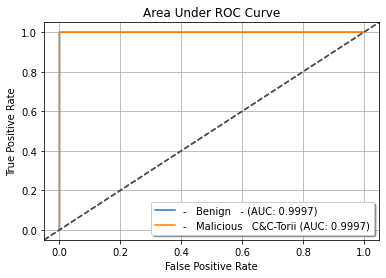

In [36]:
# Display ROC Curve

plcls.plot_roc(DT_evl, title="Area Under ROC Curve", class_index=[0, 1], wait=True)

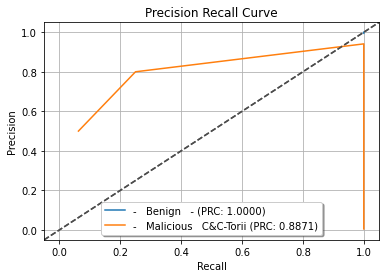

In [35]:
# Display Precision Recall Curve

plcls.plot_prc(DT_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Bayes Network

In [24]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.bayes.BayesNet").to_help()) 

weka.classifiers.bayes.BayesNet

DESCRIPTION

Bayes Network learning using various search algorithms and quality measures.
Base class for a Bayes Network classifier. Provides datastructures (network structure, conditional probability distributions, etc.) and facilities common to Bayes Network learning algorithms like K2 and B.

For more information see:

http://www.cs.waikato.ac.nz/~remco/weka.pdf

OPTIONS

-D
	Do not use ADTree data structure


-B <BIF file>
	BIF file to compare with


-Q weka.classifiers.bayes.net.search.SearchAlgorithm
	Search algorithm


-E weka.classifiers.bayes.net.estimate.SimpleEstimator
	Estimator algorithm


-output-debug-info
	If set, classifier is run in debug mode and
	may output additional info to the console

-do-not-check-capabilities
	If set, classifier capabilities are not checked before classifier is built
	(use with caution).

-num-decimal-places
	The number of decimal places for the output of numbers in the model (default 2).

-batch-size
	The desi

In [62]:
# Build and run Bayesian Network classificaiton model with default options

Nbn_cls = Classifier(classname="weka.classifiers.bayes.BayesNet")
Nbn_cls.build_classifier(dataset)

Nbn_evl = Evaluation(dataset)
Nbn_evl.crossvalidate_model(Nbn_cls, dataset, 10, Random(1))

print(Nbn_evl.matrix("=== Bayes Network ==="))

=== Bayes Network ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



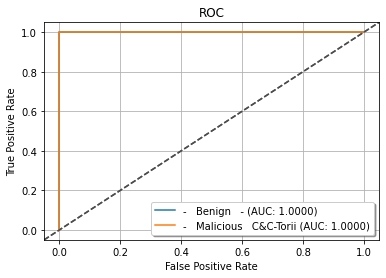

In [69]:
# Display ROC Curve

plcls.plot_roc(Nbn_evl, class_index=[0, 1], wait=True)

AdaBoost Bayes Network

In [25]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.meta.AdaBoostM1").to_help()) 

weka.classifiers.meta.AdaBoostM1

DESCRIPTION

Class for boosting a nominal class classifier using the Adaboost M1 method. Only nominal class problems can be tackled. Often dramatically improves performance, but sometimes overfits.

For more information, see

Yoav Freund, Robert E. Schapire: Experiments with a new boosting algorithm. In: Thirteenth International Conference on Machine Learning, San Francisco, 148-156, 1996.

OPTIONS

-P <num>
	Percentage of weight mass to base training on.
	(default 100, reduce to around 90 speed up)

-Q
	Use resampling for boosting.

-resume
	Set whether classifier can continue training after performing therequested number of iterations. 
	Note that setting this to true will retain certain data structures which can increase the 
	size of the model.


-S <num>
	Random number seed.
	(default 1)

-I <num>
	Number of iterations.
	(current value 10)

-W <classifier name>
	Full name of base classifier.
	(default: weka.classifiers.trees.DecisionStump)

-outpu

In [12]:
# Build and run Bayesian Network model with adaptive boosting ensemble algorithm

B_Nbn_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.bayes.BayesNet -- -D -Q weka.classifiers.bayes.net.search.local.K2 -- -P 1 -S BAYES -E weka.classifiers.bayes.net.estimate.SimpleEstimator -- -A 0.5'
B_Nbn_cls = from_commandline(B_Nbn_cmdline, classname="weka.classifiers.Classifier")
B_Nbn_cls.build_classifier(dataset)

B_Nbn_evl = Evaluation(dataset)
B_Nbn_evl.crossvalidate_model(B_Nbn_cls, dataset, 10, Random(1))
print(B_Nbn_evl.matrix("=== AdaBoost Bayes Network ==="))

=== AdaBoost Bayes Network ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



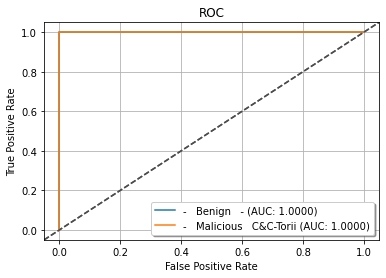

In [70]:
# Display ROC Curve

plcls.plot_roc(B_Nbn_evl, class_index=[0, 1], wait=True)

AdaBoost Decision Stump

In [22]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.trees.DecisionStump").to_help()) 

weka.classifiers.trees.DecisionStump

DESCRIPTION

Class for building and using a decision stump. Usually used in conjunction with a boosting algorithm. Does regression (based on mean-squared error) or classification (based on entropy). Missing is treated as a separate value.

OPTIONS

-output-debug-info
	If set, classifier is run in debug mode and
	may output additional info to the console

-do-not-check-capabilities
	If set, classifier capabilities are not checked before classifier is built
	(use with caution).

-num-decimal-places
	The number of decimal places for the output of numbers in the model (default 2).

-batch-size
	The desired batch size for batch prediction  (default 100).



In [14]:
# Build and run Decision Stump model with adaptive boosting ensemble algorithm 

B_DS_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.trees.DecisionStump'
B_DS_cls = from_commandline(B_DS_cmdline, classname="weka.classifiers.Classifier")
B_DS_cls.build_classifier(dataset)

B_DS_evl = Evaluation(dataset)
B_DS_evl.crossvalidate_model(B_DS_cls, dataset, 10, Random(1))
print(B_DS_evl.matrix("=== AdaBoost Decision Stump ==="))

=== AdaBoost Decision Stump ===
    a    b   <-- classified as
 3193    0 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



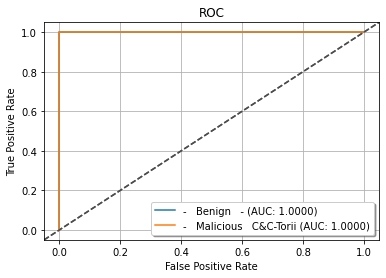

In [71]:
# Display ROC Curve

plcls.plot_roc(B_DS_evl, class_index=[0, 1], wait=True)

Naive Bayes

In [29]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.bayes.NaiveBayes").to_help()) 

weka.classifiers.bayes.NaiveBayes

DESCRIPTION

Class for a Naive Bayes classifier using estimator classes. Numeric estimator precision values are chosen based on analysis of the  training data. For this reason, the classifier is not an UpdateableClassifier (which in typical usage are initialized with zero training instances) -- if you need the UpdateableClassifier functionality, use the NaiveBayesUpdateable classifier. The NaiveBayesUpdateable classifier will  use a default precision of 0.1 for numeric attributes when buildClassifier is called with zero training instances.

For more information on Naive Bayes classifiers, see

George H. John, Pat Langley: Estimating Continuous Distributions in Bayesian Classifiers. In: Eleventh Conference on Uncertainty in Artificial Intelligence, San Mateo, 338-345, 1995.

OPTIONS

-K
	Use kernel density estimator rather than normal
	distribution for numeric attributes

-D
	Use supervised discretization to process numeric attributes


-O
	Display mod

In [46]:
# Build and run Naive Bayes model

NB_cls = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
NB_cls.build_classifier(dataset)

NB_evl = Evaluation(dataset)
NB_evl.crossvalidate_model(NB_cls, dataset, 10, Random(1))

print(NB_evl.matrix("=== Naive Bayes ==="))

=== Naive Bayes ===
    a    b   <-- classified as
 3193    0 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



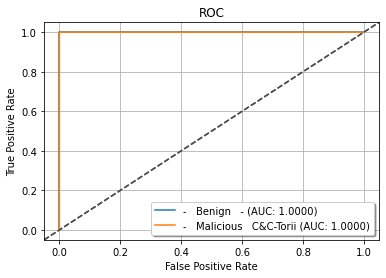

In [72]:
# Display ROC Curve

plcls.plot_roc(NB_evl, class_index=[0, 1], wait=True)

MLP Nueral Network

In [30]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.functions.MLPClassifier").to_help()) 

weka.classifiers.functions.MLPClassifier

DESCRIPTION

Trains a multilayer perceptron with one hidden layer using WEKA's Optimization class by minimizing the given loss function plus a quadratic penalty with the BFGS method. Note that all attributes are standardized, including the target. There are several parameters. The ridge parameter is used to determine the penalty on the size of the weights. The number of hidden units can also be specified. Note that large numbers produce long training times. Finally, it is possible to use conjugate gradient descent rather than BFGS updates, which may be faster for cases with many parameters. To improve speed, an approximate version of the logistic function is used as the default activation function for the hidden layer, but other activation functions can be specified. In the output layer, the sigmoid function is used for classification. If the approximate sigmoid is specified for the hidden layers, it is also used for the output layer. For regre

In [54]:
# Build and run MLP model

MLP_cls = Classifier(classname="weka.classifiers.functions.MLPClassifier")
MLP_cls.build_classifier(dataset)

MLP_evl = Evaluation(dataset)
MLP_evl.crossvalidate_model(MLP_cls, dataset, 10, Random(1))

print(MLP_evl.matrix("=== MLP Nueral Network ==="))

=== MLP Nueral Network ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    1   15 |    b = -   Malicious   C&C-Torii



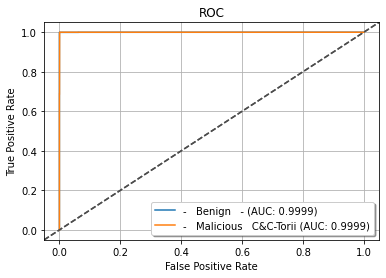

In [73]:
# Display ROC Curve

plcls.plot_roc(MLP_evl, class_index=[0, 1], wait=True)

Stochastic Gradient Descent

In [33]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.functions.SGD").to_help()) 

weka.classifiers.functions.SGD

DESCRIPTION

Implements stochastic gradient descent for learning various linear models (binary class SVM, binary class logistic regression, squared loss, Huber loss and epsilon-insensitive loss linear regression). Globally replaces all missing values and transforms nominal attributes into binary ones. It also normalizes all attributes, so the coefficients in the output are based on the normalized data.
For numeric class attributes, the squared, Huber or epsilon-insensitve loss function must be used. Epsilon-insensitive and Huber loss may require a much higher learning rate.

OPTIONS

-F
	Set the loss function to minimize.
	0 = hinge loss (SVM), 1 = log loss (logistic regression),
	2 = squared loss (regression), 3 = epsilon insensitive loss (regression),
	4 = Huber loss (regression).
	(default = 0)

-L
	The learning rate. If normalization is
	turned off (as it is automatically for streaming data), then the
	default learning rate will need to be reduced (t

In [52]:
# Build and run SGD model

SGD = Classifier(classname="weka.classifiers.functions.SGD")
SGD.build_classifier(dataset)

SGD_evl = Evaluation(dataset)
SGD_evl.crossvalidate_model(SGD, dataset, 10, Random(1))

print(SGD_evl.matrix("=== Stochastic Gradient Descent ==="))

=== Stochastic Gradient Descent ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



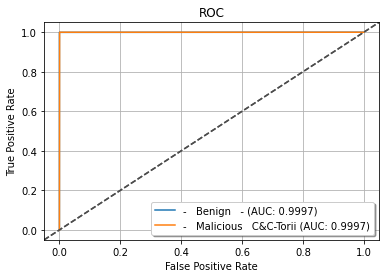

In [76]:
# Display ROC Curve

plcls.plot_roc(SGD_evl, class_index=[0, 1], wait=True)

KNN (K=1)

In [37]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.lazy.IBk").to_help()) 

weka.classifiers.lazy.IBk

DESCRIPTION

K-nearest neighbours classifier. Can select appropriate value of K based on cross-validation. Can also do distance weighting.

For more information, see

D. Aha, D. Kibler (1991). Instance-based learning algorithms. Machine Learning. 6:37-66.

OPTIONS

-I
	Weight neighbours by the inverse of their distance
	(use when k > 1)

-F
	Weight neighbours by 1 - their distance
	(use when k > 1)

-K <number of neighbors>
	Number of nearest neighbours (k) used in classification.
	(Default = 1)

-E
	Minimise mean squared error rather than mean absolute
	error when using -X option with numeric prediction.

-W <window size>
	Maximum number of training instances maintained.
	Training instances are dropped FIFO. (Default = no window)

-X
	Select the number of nearest neighbours between 1
	and the k value specified using hold-one-out evaluation
	on the training data (use when k > 1)

-A
	The nearest neighbour search algorithm to use (default: weka.core.neighbours

In [53]:
# Build and run KNN model

IBk = Classifier(classname="weka.classifiers.lazy.IBk", options=["-K","1"])
IBk.build_classifier(dataset)

IBk_evl = Evaluation(dataset)
IBk_evl.crossvalidate_model(IBk, dataset, 10, Random(1))

print(IBk_evl.matrix("=== KNN (K=1) ==="))

=== KNN (K=1) ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



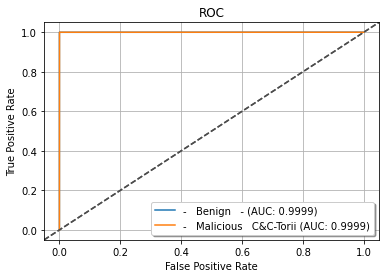

In [77]:
# Display ROC Curve

plcls.plot_roc(IBk_evl, class_index=[0, 1], wait=True)

Voting Feature Intervals

In [41]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.misc.VFI").to_help())

weka.classifiers.misc.VFI

DESCRIPTION

Classification by voting feature intervals. Intervals are constucted around each class for each attribute (basically discretization). Class counts are recorded for each interval on each attribute. Classification is by voting. For more info see:

G. Demiroz, A. Guvenir: Classification by voting feature intervals. In: 9th European Conference on Machine Learning, 85-92, 1997.

Have added a simple attribute weighting scheme. Higher weight is assigned to more confident intervals, where confidence is a function of entropy:
weight (att_i) = (entropy of class distrib att_i / max uncertainty)^-bias

OPTIONS

-C
	Don't weight voting intervals by confidence

-B <bias>
	Set exponential bias towards confident intervals
	(default = 0.6)



In [60]:
# Build and run voting feature interval model

VFI = Classifier(classname="weka.classifiers.misc.VFI")
VFI.build_classifier(dataset)

VFI_evl = Evaluation(dataset)
VFI_evl.crossvalidate_model(VFI, dataset, 10, Random(1))

print(VFI_evl.matrix("=== Voting Feature Intervals ==="))

=== Voting Feature Intervals ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



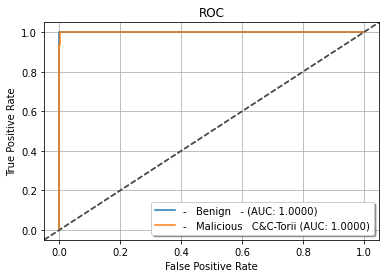

In [78]:
# Display ROC Curve

plcls.plot_roc(VFI_evl, class_index=[0, 1], wait=True)

Sequential Minimal Optimization SVM

In [63]:
# Run to_help function to view algorithm description and options details

print(Classifier(classname="weka.classifiers.functions.SMO").to_help())

weka.classifiers.functions.SMO

DESCRIPTION

Implements John Platt's sequential minimal optimization algorithm for training a support vector classifier.

This implementation globally replaces all missing values and transforms nominal attributes into binary ones. It also normalizes all attributes by default. (In that case the coefficients in the output are based on the normalized data, not the original data --- this is important for interpreting the classifier.)

Multi-class problems are solved using pairwise classification (aka 1-vs-1).

To obtain proper probability estimates, use the option that fits calibration models to the outputs of the support vector machine. In the multi-class case, the predicted probabilities are coupled using Hastie and Tibshirani's pairwise coupling method.

Note: for improved speed normalization should be turned off when operating on SparseInstances.

For more information on the SMO algorithm, see

J. Platt: Fast Training of Support Vector Machines using Seq

In [65]:
# Build and run SMO SVM model

SMO = Classifier(classname="weka.classifiers.functions.SMO")
SMO.build_classifier(dataset)

SMO_evl = Evaluation(dataset)
SMO_evl.crossvalidate_model(SMO, dataset, 10, Random(1))

print(SMO_evl.matrix("=== Sequential Minimal Optimization SVM ==="))

=== Sequential Minimal Optimization SVM ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii



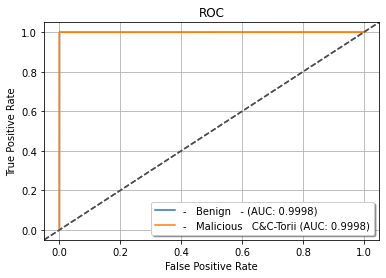

In [79]:
import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(SMO_evl, class_index=[0, 1], wait=True)

Stop Java VM

In [3]:
# Stop JVM. May need to restart compute cluster or jupyter kernal if jvm restart is required.

jvm.stop()